# 6. The Laplacian Pyramid

In [120]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image

## 6.1 The basic concept

<figure id="figure-2">
<div style="background-color: white">

![](figures/laplacian.svg)</div>
    
<figcaption style="text-align: center">Figure 2: A typical laplacian pyramid with 2 levels; forward (analysis) part only</figcaption>
</figure>

The Laplacian pyramid is an energy compaction technique, based on
the observation:

> For most real-world images, the high-frequency energy is much less than the low-frequency energy.

Since the lowpass image is much lower bandwidth than the
original image, it can be subsampled (*decimated*) 2:1 in both
horizontal and vertical directions, without significant loss of
information to give a quarter-size lowpass image.  We have
provided a row filter/decimation function, `rowdec(X, h)`, to
filter and decimate the rows of a matrix by 2:1.

In [121]:
from cued_sf2_lab.laplacian_pyramid import rowdec

Use this twice
(on the image and its transpose) to generate a quarter-size
lowpass image `X1` of Lighthouse.  For simplicity use a 3-tap (length 3)
filter `h` with coefficients: $\frac{1}{4} [1\ 2\ 1]$.

In [122]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})

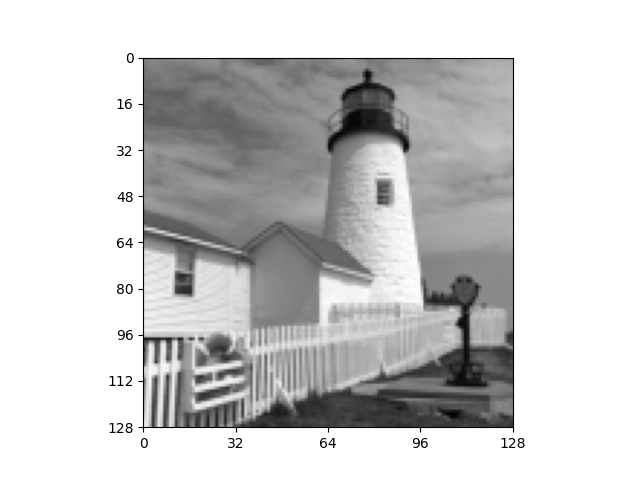

In [123]:
h = 0.25*np.array([1, 2, 1])
X1 = rowdec(rowdec(X,h).T,h).T  # your code here

fig,ax = plt.subplots()
plot_image(X1,ax=ax)

The image `X1` can be interpolated 2:1 in each direction to
generate a lowpass image of the original size, which can then be
subtracted from the original to yield a full-size highpass image.
We have also provided a row interpolation/filter function,
`rowint(X, h)`, which doubles the length of each row of the image, by
inserting zeros between alternate samples and then lowpass
filtering the result with the filter `h`. Note that to undo the decimation
performed by `Y = rowdec(X, h)`, this should be called as `Z = rowint(Y, 2*h)`,
where a DC gain of 2 is added, as shown in [Figure 2](#figure-2).

In [124]:
from cued_sf2_lab.laplacian_pyramid import rowint

Apply this twice (as before) to generate
a full-size lowpass image, and subtract this from `X` to
give a highpass image `Y0`. Display `X1` and `Y0` to see these effects.

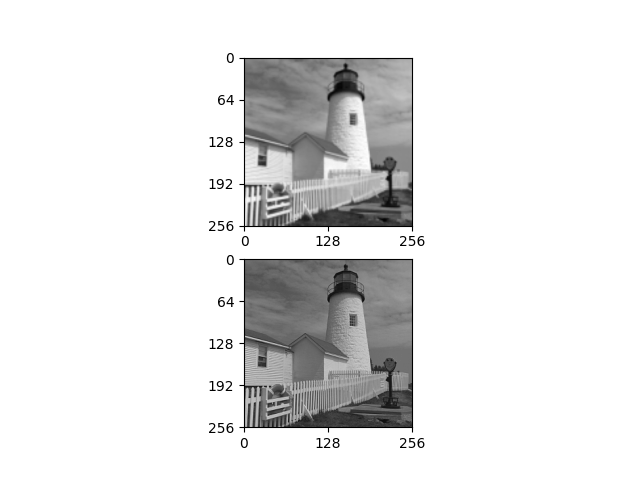

In [125]:
# your code here
X_fullsize = rowint(rowint(X1,h).T,h).T
Y0 = X - X_fullsize
fig2, ax2 = plt.subplots(2)
plot_image(X_fullsize, ax=ax2[0])
plot_image(Y0,ax=ax2[1])

The highpass images will
always have approximately zero mean (since any dc component is
removed). Hence for the remainder of this project, we recommend
that you also make all lowpass images be approximately zero mean
by subtracting 128 from them before you start any processing. This
makes the 8-bit pixel values cover the range -128 to 127,
instead of 0 to 255. The advantages of having a zero-mean input image are not very obvious here, but they
will become clearer as the project progresses. If you use `draw_image` the images will still be displayed correctly.

In [126]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

Examine the functions ```rowdec``` and ```rowint``` and check that you understand how they work. Decimation is achieved by selecting every second element of a vector using selection indices `i:i+c:2`, and filtering is performed with symmetric extension as in ```convse```, except that we do not bother to calculate the filter outputs that are to be discarded by the decimation process. Interpolation is achieved by loading every second element of a double-size vector using `X2 = np.zeros((r, c2), dtype=X.dtype)`, `X2[:, ::2] = X`. The intermediate samples of the interpolated vector x must be zero before the vector is passed through the interpolation filter.

In [127]:
IPython.display.Code(inspect.getsource(rowdec), language="python")

def rowdec(X: np.ndarray, h: np.ndarray) -> np.ndarray:
    """
    Filter rows of image X with h and then decimate by a factor of 2.

    Parameters:
        X: Image matrix (Usually 256x256)
        h: Filter coefficients
    Returns:
        Y: Image with filtered and decimated rows

    If len(H) is odd, each output sample is aligned with the first of
    each pair of input samples.
    If len(H) is even, each output sample is aligned with the mid point
    of each pair of input samples.
    """
    r, c = X.shape
    m = len(h)
    m2 = m // 2
    if m % 2:
        X = np.pad(X, [(0, 0), (m2, m2)], mode='reflect')
    else:
        X = np.pad(X, [(0, 0), (m2-1, m2-1)], mode='symmetric')

    Y = np.zeros((r, (c+1)//2))
    # Loop for each term in h.
    for i in range(m):
        Y = Y + h[i] * X[:, i:i+c:2]
    return Y

In [128]:
IPython.display.Code(inspect.getsource(rowint), language="python")

def rowint(X: np.ndarray, h: np.ndarray) -> np.ndarray:
    """
    Interpolates the rows of image X by 2 using h.

    Parameters:
        X: Image matrix (Usually 256x256)
        h: Filter coefficients
    Returns:
        Y: Image with interpolated rows

    If len(h) is odd, each input sample is aligned with the first of
    each pair of output samples.
    If len(h) is even, each input sample is aligned with the mid point
    of each pair of output samples.
    """
    r, c = X.shape
    m = len(h)
    m2 = m // 2
    c2 = 2 * c

    # Generate X2 as X interleaved with columns of zeros.
    X2 = np.zeros((r, c2), dtype=X.dtype)
    X2[:, ::2] = X

    X2 = np.pad(X2, [(0, 0), (m2, m2)], mode='reflect' if m % 2 else 'symmetric')

    Y = np.zeros((r, c2))
    # Loop for each term in h.
    for i in range(m):
        Y = Y + h[i] * X2[:, i:i+c2]
    return Y

If the small lowpass image `X1` and the full-size highpass image `Y0`
are transmitted to a distant decoder, then the decoder can exactly reconstruct
the original image by interpolating `X1` up to full size and adding in
`Y0` (which represents the error between the original and the interpolated
`X1`).  We have achieved image compression if `X1` and `Y0` can be
transmitted with fewer bits than `X`.  Usually this will be the case
because `Y0` contains so much less energy than `X`, and `X1` is
only one quarter of the size of `X`.  However we do start at a
disadvantage because there are 25% more samples to code.  Many of the `Y0` samples may be represented by zero, and we shall show later that runs of
zeros may be coded with relatively few bits.

The quarter-size lowpass image `X1` may be further subsampled, using the
same process as was applied to `X`, so that it may be transmitted as a
one-sixteenth-size lowpass image `X2` and a quarter-size highpass image
`Y1`.  This usually achieves further data compression and may be repeated
as many times as is desired (until, for typical images, no further compression
is achieved).  This leads to a pyramid of highpass images and a final tiny
lowpass image.  Usually three or four layers of the pyramid are sufficient to
give maximum compression.

Write a `py4enc(X, h)` function to generate a 4-layer pyramid, so that `X` is split into four
highpass images, `Y0 Y1 Y2 Y3`, each a quarter of the size of its predecessor, plus a tiny
lowpass image `X4`, which is a quarter of the size of `Y3`.

In [129]:
def py4enc(X, h):
    # your code here
    X1 = rowdec(rowdec(X,h).T,h).T #1/4
    X2 = rowdec(rowdec(X1,h).T,h).T
    X3 = rowdec(rowdec(X2,h).T,h).T
    X4 = rowdec(rowdec(X3,h).T,h).T
    

    Y0 = X - rowint(rowint(X1,2*h).T,2*h).T
    Y1 = X1 - rowint(rowint(X2,2*h).T,2*h).T
    Y2 = X2 - rowint(rowint(X3,2*h).T,2*h).T
    Y3 = X3 - rowint(rowint(X4,2*h).T,2*h).T

    return Y0, Y1, Y2, Y3, X4

#Generate 2-stage pyramid
def py2enc(X,h):
    X1 = rowdec(rowdec(X,h).T,h).T #1/4
    X2 = rowdec(rowdec(X1,h).T,h).T
    
    Y0 = X - rowint(rowint(X1,2*h).T,2*h).T
    Y1 = X1 - rowint(rowint(X2,2*h).T,2*h).T

    return Y0, Y1, X2    


We can then plot the results to check them using the `beside` helper function:

In [130]:
from cued_sf2_lab.laplacian_pyramid import beside

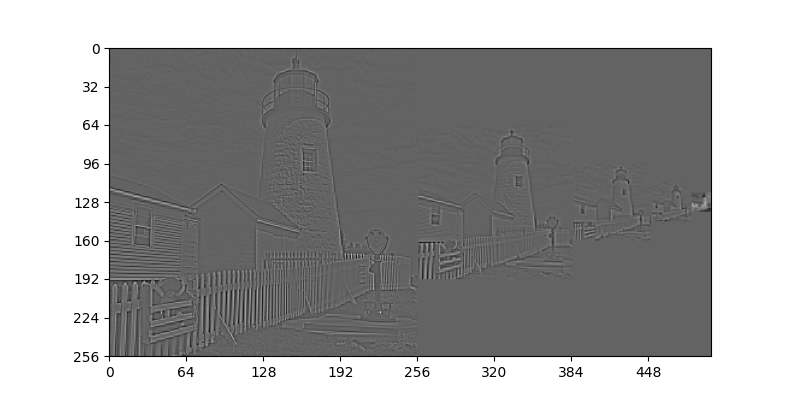

In [131]:
Y0, Y1, Y2, Y3, X4 = py4enc(X, h)
fig, ax = plt.subplots(figsize=(8, 4))
plot_image(beside(Y0, beside(Y1, beside(Y2, beside(Y3, X4)))), ax=ax)

If we wish to see the images separately from each other, instead of using our `beside` function that was written to match the old Matlab version, we can draw this directly with `matplotlib` using [`plt.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) to create a set of subplots, and the `width_ratios` argument to [`GridSpec`](https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html):

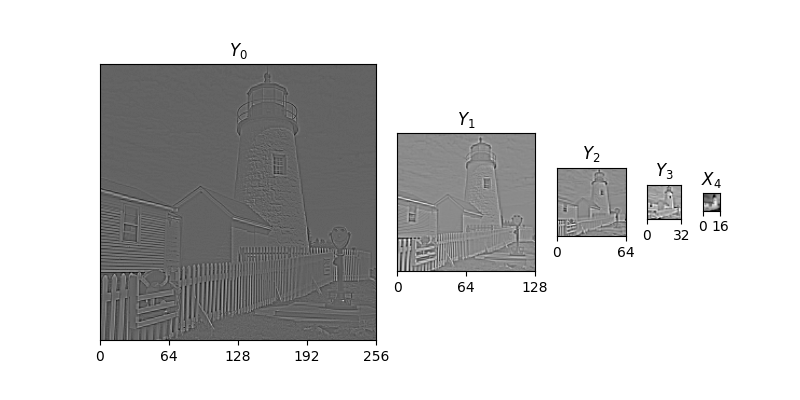

In [132]:
titles = ["Y_0", "Y_1", "Y_2", "Y_3", "X_4"]
imgs = [Y0, Y1, Y2, Y3, X4]
fig, axs = plt.subplots(1, 5, figsize=(8, 4), gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs]))
#gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs])
#specifies the size of ratio of the images

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

If we wish to see the images at the same scale as each other, we can use:

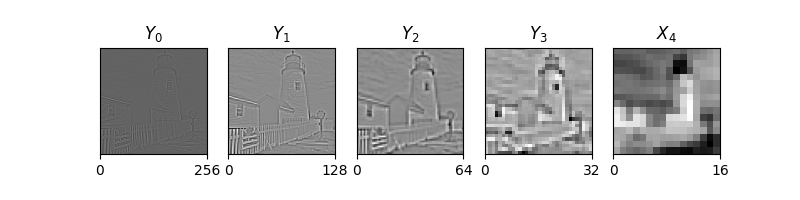

In [133]:
titles = ["Y_0", "Y_1", "Y_2", "Y_3", "X_4"]
imgs = [Y0, Y1, Y2, Y3, X4]
fig, axs = plt.subplots(1, 5, figsize=(8, 2))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

Get a demonstrator to check that your images look correct, and
then write another function `py4dec` to decode `X4` and
`Y3 Y2 Y1 Y0` into a set of lowpass images `Z3 Z2 Z1 Z0`.
(`Z3` is obtained by interpolating `X4` and adding
`Y3`, and then `Z2` is obtained from `Z3` and `Y2`, and
so on.)

In [134]:
def py4dec(Y0, Y1, Y2, Y3, X4, h):
    # your code here
    Z3 = Y3 + rowint(rowint(X4,2*h).T,2*h).T
    Z2 = Y2 + rowint(rowint(Z3,2*h).T,2*h).T
    Z1 = Y1 + rowint(rowint(Z2,2*h).T,2*h).T
    Z0 = Y0 + rowint(rowint(Z1,2*h).T,2*h).T

    return Z3, Z2, Z1, Z0

#Reconstruct 2-stage pyramid

def py2dec(Y0, Y1, X2, h):
    Z1 = Y1 + rowint(rowint(X2,2*h).T,2*h).T
    Z0 = Y0 + rowint(rowint(Z1,2*h).T,2*h).T

    return Z1, Z0

In [135]:
def py_enc(X, h, stages):
    """Encoding of Laplacian pyramid with arbitrary stages"""

    Xs = [X]  # List to hold X and its reduced versions
    Ys = []   # List to hold Y layers

    # Generate reduced versions and Y layers
    for i in range(stages):
        X_next = rowdec(rowdec(Xs[-1], h).T, h).T
        Y = Xs[-1] - rowint(rowint(X_next, 2*h).T, 2*h).T
        Xs.append(X_next)
        Ys.append(Y)

    return Ys, Xs[-1]  # Return all Y layers and the last X reduced version

def py_dec(Ys, X_last, h):
    """Decoding of Laplacian pyramid with arbitrary stages"""
    
    # Start from the smallest image
    Z = X_last

    # Iterate through the Y layers in reverse order to reconstruct the image
    for Y in reversed(Ys):
        Z = Y + rowint(rowint(Z, 2*h).T, 2*h).T

    return Z

If all is correct, `Z0` should be identical to
`X`.  You can check that your function is correct by calculating `np.max(abs(X - Z0))` and also displaying your pyramid of decoded images, `Z3` to `Z0`.

Encode-Decode Error = 0.0


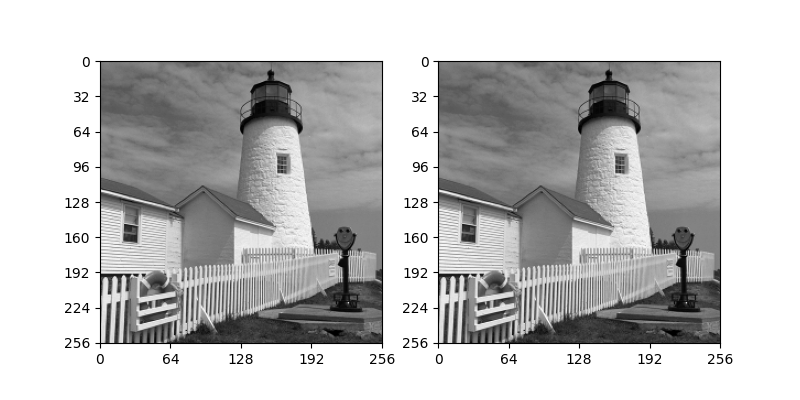

In [136]:
h = 0.25*np.array([1, 2, 1])
Z3, Z2, Z1, Z0 = py4dec(Y0, Y1, Y2, Y3, X4, h)
encode_decode_err = np.max(np.abs(X - Z0))
print(f'Encode-Decode Error = {encode_decode_err}')

# your code here to plot the images
fig, axs = plt.subplots(1,2,figsize=(8,4))
plot_image(Z0,ax=axs[0])
plot_image(X,ax=axs[1])

For further information on the Laplacian Pyramid see Burt and Adelson [IEEE Trans. on Communications, 1983, vol 31, no 4, pp 532-540, "The Laplacian Pyramid as a compact image code"].

## 6.2 Quantisation and Coding Efficiency
To see whether data compression is possible using the above pyramid decomposition, we must calculate the approximate number of bits required to code the image pyramid. This may be done using the *entropy* of the quantised image data. 

The entropy of a single data sample, whcih may randomly take one of $Q$ possible quantised values such that each value $q(i)$ has a probability $p(i)$ of being in state $i$ for $i=1\to Q$ is given by:

$$ \text{Entropy (bits/sample)} = \sum_{i=1}^Qp(i) \log_2\frac{1}{p(i)} = -\sum_{i=1}^Q p(i) \log_2p(i)$$

The entropy represents the minimum average number of bits per sample needed to code samples with the given probability distribution $p(i)$, assuming that an ideal variable-length entropy code is used, and that the samples are uncorrelated with each other. Arithmetic codes can get arbitrarily close to this bit rate, and simpler Huffman codes can also get vary close with many typical signals (you will be using Huffman codes later on). It is possible to code signals at bit rates less than the entropy, if the samples are correlated, but for simplicity we shall ignore this here.

To demonstrate the validity of the above formula, first consider a signal with 8 quantised values of equal probability $p(i) = 1/8$ for all $i$. The entropy is then $8 \times 1/8 \times \log_2(8) = 3$ bits per sample, as expected. 

Now consider a signal with only 3 values, with probabilities $p(1)=1/2$,  $p(2) = p(3) = 1/4$. The entropy is then $\frac{1}{2} \log_2(2) + 2 \times \frac{1}{4} \log_2(4) = 1.5$ bits per sample. This is consistent with using a single bit '0' to represent state 1 and two bits, '10' and '11' to represent states 2 and 3.

The function `bpp` has been written to calculate the entropy in bits per pixel of an image matrix `X`. First the function computes a histogram of `X` to determine the probabilities $p(i)$ and then it calculates the entropy, using the above formula.

In [137]:
from cued_sf2_lab.laplacian_pyramid import bpp
IPython.display.Code(inspect.getsource(bpp), language="python")

def bpp(x):
    """
    Calculate the entropy in bits per element (or pixel) for matrix x

    The entropy represents the number of bits per element to encode x
    assuming an ideal first-order entropy code.
    """
    minx = np.min(x, axis=None)
    maxx = np.max(x, axis=None)
    # Calculate histogram of x in bins defined by bins.
    bins = list(range(int(np.floor(minx)), int(np.ceil(maxx)+1)))
    if len(bins) < 2:
        # in this case there is no information, as all the values are identical
        return 0

    h, s = np.histogram(x, bins)

    # Convert bin counts to probabilities, and remove zeros.
    p = h / np.sum(h)
    p = p[p > 0]

    # Calculate the entropy of the histogram using base 2 logs.
    return -np.sum(p * np.log(p)) / np.log(2)

In the Laplacian Pyramid, the total number of bits is obtained by multiplying each of the sub-image entropies by the number of pixels in each corresponding sub-image. However, in order to compress the data, we also need to quantise the images. We have also provided a function `quantise` which will quantise `X` in steps centred on integer multiples of `step`. Hence `bpp(quantise(X, step))` will return the entropy of image `X` quantised in steps of `step`.

In [138]:
from cued_sf2_lab.laplacian_pyramid import quantise
IPython.display.Code(inspect.getsource(quantise), language="python")

def quantise(x, step, rise1=None):
    """
    Quantise matrix x in one go with step width of step using quant1 and quant2

    If rise1 is defined, the first step rises at rise1, otherwise it rises at
    step/2 to give a uniform quantiser with a step centred on zero.
    In any case the quantiser is symmetrical about zero.
    """
    if step <= 0:
        y = x.copy()
        return y
    if rise1 is None:
        rise = step/2.0
    else:
        rise = rise1
    # Perform both quantisation steps
    y = quant2(quant1(x, step, rise), step, rise)
    return y

<div class="alert alert-block alert-danger">

Calculate the entropies of images `X` `X1` `Y0` and hence the total numbers of bits to encode `X`, or `X1` and `Y0`, when quantised to a step size of 17 (which gives 15 distict grey levels if applied to a lowpass image with intensities from -127 to 127. Find the data compression for this simple one-stage pyramid, and then investigate the improvements from using more layers.
</div>

In [139]:
# Write your code to calculate compression ratios here.
#Encode 1-stage pyramid
X1 = rowdec(rowdec(X,h).T,h).T
Y0 = X - rowint(rowint(X1,h).T,h).T
print(X,X1,Y0)

en_X = bpp(quantise(X,17))
en_X1 = bpp(quantise(X1,17))
en_Y0 = bpp(quantise(Y0,17))
print(en_X, en_X1, en_Y0)
bit_X = en_X * len(X)
bit_X1 = en_X1 * len(X1)
bit_Y0 = en_Y0 * len(Y0)
print(bit_X, bit_X1, bit_Y0)

#Compression ratio = bits needed before compression  / bits needed after compression
comp_ratio = (bit_Y0 + bit_X1) / bit_X 
print("Compression ratio:", comp_ratio)

#Investigate more layers of pyramid
Y0, Y1, Y2, Y3, X4 = py4enc(X, h)
en_X4 = bpp(quantise(X4,17))
en_Y0 = bpp(quantise(Y0,17))
bit_X4 = en_X4 * len(X4)
comp_ratio_4 = (bit_Y0 + bit_X4) / bit_X
print("Compression ratio of 4-layer:", comp_ratio_4)


[[ -4. -11.  -9. ...  12.  16.  21.]
 [ -9. -11. -10. ...  23.  22.  25.]
 [ -7. -11.  -8. ...  30.  31.  31.]
 ...
 [ 79.  85.  87. ... -97. -92. -88.]
 [ 84.  86.  85. ... -75. -75. -70.]
 [ 86.  85.  85. ... -63. -59. -66.]] [[ -8.75    -9.25    -4.875  ...  19.25    16.625   19.625 ]
 [ -9.75    -9.375   -6.0625 ...  27.9375  28.25    29.375 ]
 [-14.25   -11.0625  -8.1875 ...  31.25    31.8125  33.0625]
 ...
 [ 73.125   86.625   43.5    ... -75.375  -71.75   -68.0625]
 [ 81.125   86.1875  38.0625 ... -66.     -70.125  -80.0625]
 [ 84.375   85.      26.1875 ... -71.25   -71.625  -75.375 ]] [[ -1.8125      -8.75        -6.6875     ...   7.46875     11.09375
   16.09375   ]
 [ -6.6875      -8.6796875   -7.671875   ...  17.1328125   15.875
   18.875     ]
 [ -4.5625      -8.609375    -5.65625    ...  22.796875    23.65625
   23.65625   ]
 ...
 [ 58.3125      63.95703125  65.6015625  ... -78.42578125 -72.5703125
  -68.5703125 ]
 [ 62.90625     64.828125    63.75       ... -56.625      -

In [140]:
#Compression ratios for multiple layers

def constant_step_comp_ratio(X,Ys,X_last,step_size):
    X_q = quantise(X,17)
    Ys_q = []
    for Y in Ys:
        Ys_q.append(quantise(Y,step_size))
    X_last_q = quantise(X_last,step_size)

    bit_X = bpp(X_q) * len(X_q)**2

    comp_bit_sum = 0
    for Y in Ys_q:
        comp_bit_sum += bpp(Y) * len(Y)**2
    comp_bit_sum += bpp(X_last_q) * len(X_last_q)**2

    comp_ratio = bit_X / comp_bit_sum
    return comp_ratio

Ys_1, X_1 = py_enc(X,h,1)
comp_ratio_1 = constant_step_comp_ratio(X,Ys_1,X_1,17)
print("1 stage:", comp_ratio_1)

Ys_2, X_2 = py_enc(X,h,2)
comp_ratio_2 = constant_step_comp_ratio(X,Ys_2,X_2,17)
print("2 stage:", comp_ratio_2)

Ys_3, X_3 = py_enc(X,h,3)
comp_ratio_3 = constant_step_comp_ratio(X,Ys_3,X_3,17)
print("3 stage:", comp_ratio_3)

Ys_4, X_4 = py_enc(X,h,4)
comp_ratio_4 = constant_step_comp_ratio(X,Ys_4,X_4,17)
print("4 stage:", comp_ratio_4)

Ys_5, X_5 = py_enc(X,h,5)
comp_ratio_5 = constant_step_comp_ratio(X,Ys_5,X_5,17)
print("5 stage:", comp_ratio_5)

Ys_8, X_8 = py_enc(X,h,8)
comp_ratio_8 = constant_step_comp_ratio(X,Ys_8,X_8,17)
print("8 stage:", comp_ratio_8)

1 stage: 1.406814651240581
2 stage: 1.599247333158242
3 stage: 1.6498864463331369
4 stage: 1.6608214118976632
5 stage: 1.662104532853784
8 stage: 1.6620045780266717


Since compressing an image will generally result in a reduction in quality, we also need a way to measure this quality reduction. It is actually quite hard to find a quality measure whcih matches individual perceptions of how an image has been changed due to compression, and for that reason it is important to always judge and comment on an image visually. However we also need a quantitative measure, and the most obvious is the rms error (standard deviation) between the input and compressed image (i.e. using ```np.std(X - Z)``` where `Z` is the compressed image).

<div class="alert alert-block alert-danger">
Quantise the Laplacian pyramid with a step size of 17, and reconstruct the output image from the decoding pyramid. Look at the visual features, and calculate the rms error (standard deviation) between the input image and the decoding pyramid output image. Repeat this for more layers in the pyramid.
</div>

RMS =  5.382782204619935


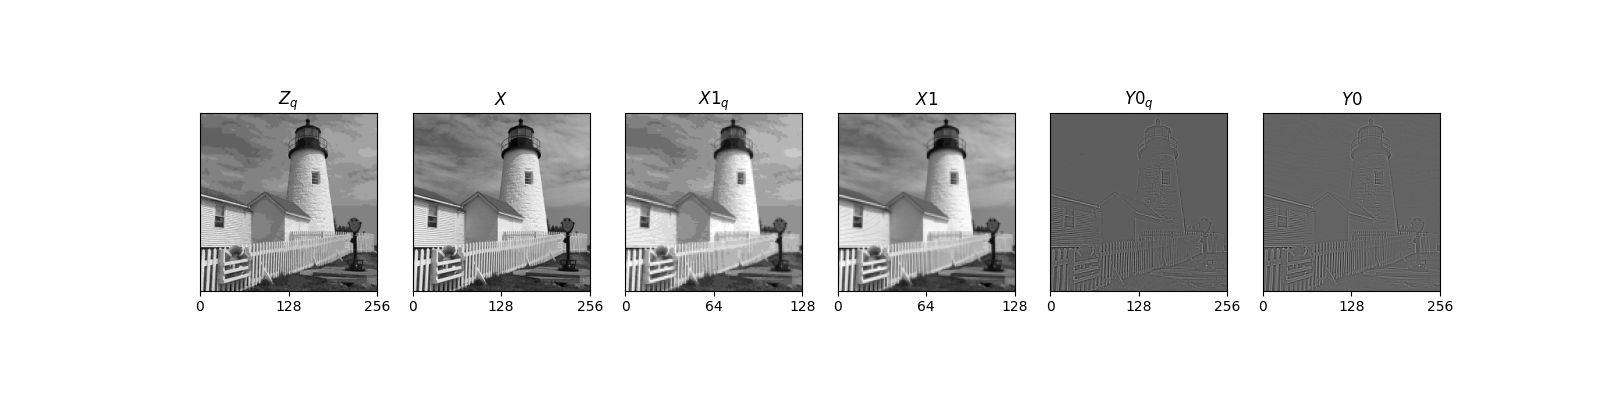

In [141]:
# Write your code to explore rms error with the laplacian pyramid here.\
X1 = rowdec(rowdec(X,h).T,h).T
X1_q = quantise(X1, 17)
Y0 = X - rowint(rowint(X1,2*h).T,2*h).T
Y0_q = quantise(Y0,17)

#reconstruct with quantized pyramid
Z_q = Y0_q + rowint(rowint(X1_q,2*h).T,2*h).T
imgs = [Z_q, X, X1_q, X1, Y0_q, Y0]
titles = ["Z_q", "X", "X1_q", "X1", "Y0_q","Y0"]
fig, axs = plt.subplots(1, 6, figsize=(16, 4))
#, gridspec_kw=dict(width_ratios=[img.shape[0] for img in imgs])

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

rms = np.std(X-Z_q)
print("RMS = ",rms)

In [159]:
# RMS error for multiple layers

def calc_rms(X,h,stages,step_size):
    
    Ys, X_last = py_enc(X,h,stages)
    Ys_q = []
    for Y in Ys:
        Ys_q.append(quantise(Y,step_size))
    X_last_q = quantise(X_last, step_size)
    Z_q = py_dec(Ys_q, X_last_q, h)

    rms = np.std(X-Z_q)
    return rms

print("RMS_1 = ",calc_rms(X,h,1,17))
print("RMS_2 = ",calc_rms(X,h,2,17))
print("RMS_3 = ",calc_rms(X,h,3,17))
print("RMS_4 = ",calc_rms(X,h,4,17))
print("RMS_5 = ",calc_rms(X,h,5,17))
print("RMS_8 = ",calc_rms(X,h,8,17))

RMS_1 =  5.117732034818226
RMS_2 =  5.634516236931645
RMS_3 =  6.189202653317099
RMS_4 =  6.81590202097939
RMS_5 =  7.58983028644312
RMS_8 =  8.274920835699694


Note that we call this error the rms error, but in fact we calculate the standard deviation, which only equals the true rms error if the mean error is zero. However the eye is very insensitive to small errors in the mean level of images, so the standard deviation (which ignores the mean) is a better measure of image quality. 

<div class="alert alert-block alert-danger">
Quantise the original image with the same step size (17) and note the visual features and rms error. Compare these results from the pyramid scheme above. Why are the rms errors larger in the pyramid scheme? 
</div>

RMS =  4.861168497356846


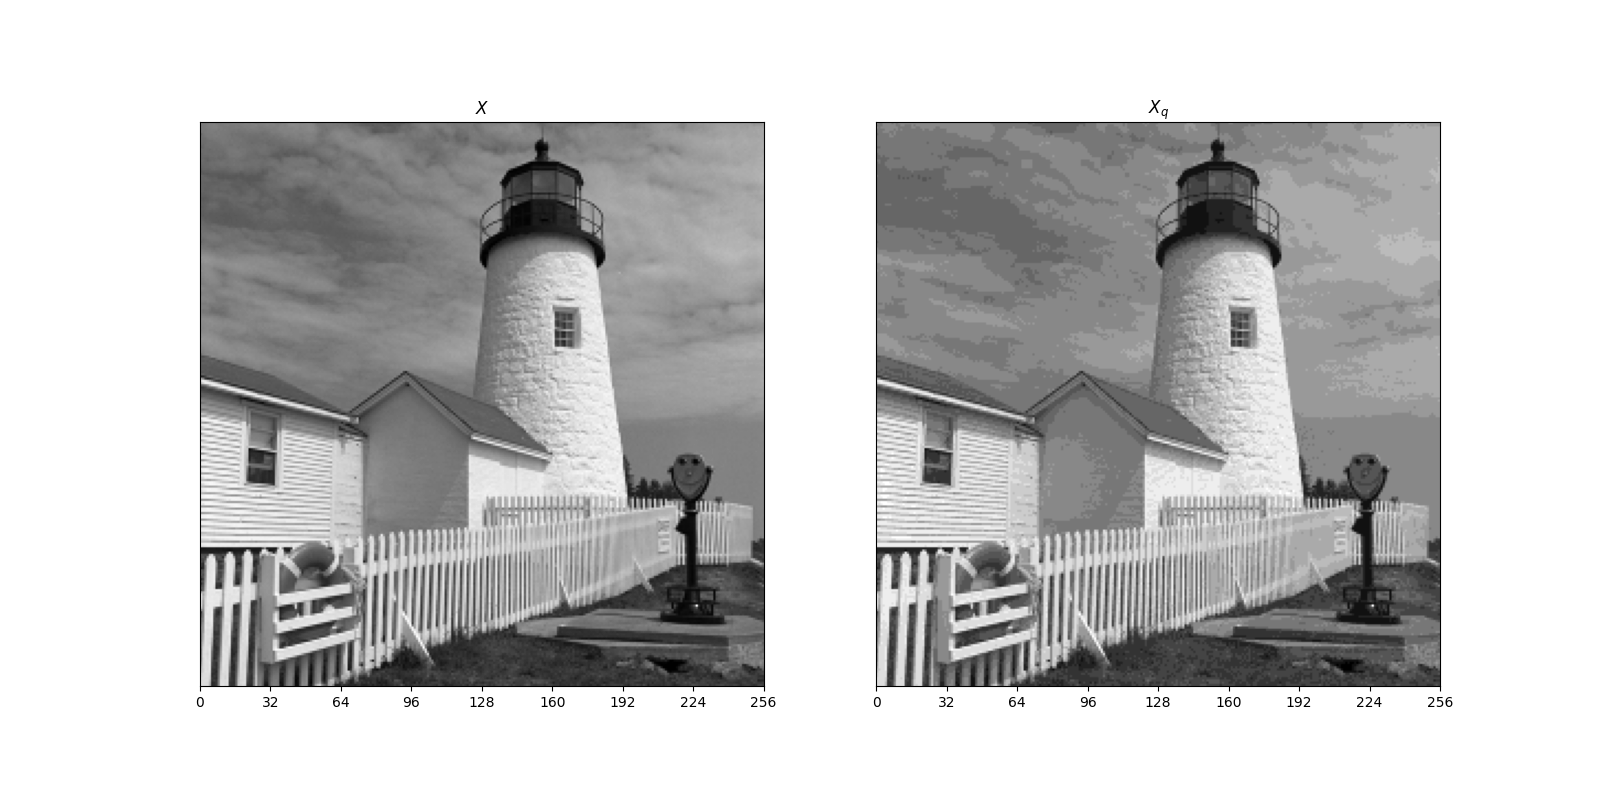

In [143]:
# Write your code to calculate the error from directly quantising the original
# image.
X_q = quantise(X,17)
imgs = [X,X_q]
titles = ["X","X_q"]
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

rms = np.std(X-X_q)
print("RMS = ",rms)

Comparisons of the number of bits with different coding strategies are only valid if they result in approximately the same image quantisation error. Write a function which will optimise the step size (resulting in a non-integer value) in the Laplacian scheme until the rms error is the same as for direct quantisation; you will find this optimisation useful for later investigations too.
<div class="alert alert-block alert-danger">
Investigate what step size of the quantisers for the pyramid scheme you need, in order to get approximately the same error as for direct quantisation at a step size of 17.
</div>

In [144]:
# Write your optimisation and step size selection here
rmss = []
step_range = np.linspace(0,256,1000)
for step_size in step_range:
    X_q = quantise(X,17)
    X1_q = quantise(X1, step_size)
    Y0_q = quantise(Y0,step_size)
    Z_q = Y0_q + rowint(rowint(X1_q,2*h).T,2*h).T
    rms_dif = np.std(X-Z_q) - np.std(X-X_q)
    rmss.append(abs(rms_dif))

print(rmss)
print(step_range)
min_dif = np.min(rmss)
opt_step_size_key = rmss.index(min_dif)
opt_step_size = step_range[opt_step_size_key]
print("Optimal step size is:", opt_step_size)
print(min_dif)


def opt_step_2stage(X, X1, Y0):
    rmss = []
    step_range = np.linspace(0,256,1000)
    for step_size in step_range:
        X_q = quantise(X,17)
        X1_q = quantise(X1, step_size)
        Y0_q = quantise(Y0,step_size)
        Z_q = Y0_q + rowint(rowint(X1_q,2*h).T,2*h).T
        rms_dif = np.std(X-Z_q) - np.std(X-X_q)
        rmss.append(abs(rms_dif))

    min_dif = np.min(rmss)
    opt_step_size_key = rmss.index(min_dif)
    opt_step_size = step_range[opt_step_size_key]
    
    return opt_step_size

[4.861168497356846, 4.768711836309162, 4.6752422529269735, 4.584225799284887, 4.4934212236798965, 4.398317529917215, 4.307875070243404, 4.214944433300443, 4.121821458760169, 4.026609440434462, 3.9343039324424884, 3.839666387680225, 3.7504438531139206, 3.6678709419562256, 3.575670664008665, 3.486015364727769, 3.4022570025195527, 3.303411288731273, 3.2291306647848357, 3.143247345240304, 3.059425345107985, 2.9815860734058117, 2.9054400290471594, 2.819472768604204, 2.741598220592238, 2.657918472656564, 2.5881361355854926, 2.498297379962076, 2.43501327569175, 2.3475595619921887, 2.266504325328015, 2.199761233096757, 2.1223702156134596, 2.0539439074782173, 1.9656833177407518, 1.8758663460799179, 1.7951323090960254, 1.7294676573316803, 1.6492587964591063, 1.5696187453534933, 1.4954122942352446, 1.4129567750724359, 1.3427531311374623, 1.252647888956135, 1.1792124025658972, 1.1161159602446098, 1.0489330886502901, 0.9716150762757323, 0.8922598091604654, 0.8010445421784338, 0.7216667629082414, 0.

In [145]:
def opt_step_multi_stage(X, h, stages):
    """Optimize the step size for a multi-stage pyramid to match the RMS error of direct quantization."""
    """stages: integer - The number of pyramid stages"""
    
    rmss = []
    step_range = np.linspace(0, 256, 1000)
    target_rms_error = np.std(X - quantise(X, 17))

    # Encode the pyramid once outside the loop
    Ys, X_last = py_enc(X, h, stages)

    for step_size in step_range:
        # Quantize Ys and X_last
        quantized_Ys = [quantise(Y, step_size) for Y in Ys]
        quantized_X_last = quantise(X_last, step_size)

        # Decode using quantized values
        reconstructed = py_dec(quantized_Ys, quantized_X_last, h)

        # Calculate RMS error
        rms_error = np.std(X - reconstructed)
        rmss.append(abs(rms_error - target_rms_error))

    min_dif = np.min(rmss)
    opt_step_size_key = rmss.index(min_dif)
    opt_step_size = step_range[opt_step_size_key]
    
    return opt_step_size

In many of your results from now on you will need to expres the performance of your algorithms in terms of *compression ratio*, which is normally defined as:

$$ \text{Compression Ratio} = \frac{\text{Total bits for reference scheme}}{\text{Total bits for compressed scheme}} $$

Usually the *reference* scheme is the direct pixel quantisation method with its quantiser adjusted to give the same rms error as the scheme being evaluated (the *compressed* scheme). For good schemes we try to make the compression ratio as large as possible.

We now investigate the effect of using different step sizes for the different levels of the pyramid. There are many schemes for varying the step sizes between different levels: in this project we shall look at the *equal MSE* criterion. In the *equal MSE* scheme, step sizes are chosen such that quantisers in each layer contribute equally to the Mean Squared Error of the reconstructed image. In general the step sizes will depend on the image signal being coded. However this can be achieved approximately by choosing a separate step size for each layer such that:
* A single impulse of that step size will give a filtered pulse in the reconstructed image which has the same energy, whichever layer of the decoder the impulse excites.

### Impulse Response Measurement
Investigate the effect of a single impulse in a particular layer (e.g. **Y0,Y1** etc.) as it appears in the reconstructed image **Z0**. This can be done by first generating a test pyramid image, which is zero everywhere. Then place an impulse (e.g. of amplitude 100) in the centre of one layer, reconstruct the entire pyramid to give **Z0**, then measure the total energy of **Z0**. If this is repeated for each layer, you will have measured how much energy a fixed size impulse at each layer contributes to the decoded image.

We actually want to arrange for the impulse sizes to vary and the energy to stay the same. Therefore the impulse sizes (and hence chosen quantisation steps) we require in each level will be inversely proportional to the square root of the energies measured above. The important result is the *ratio* of the step sizes between layers. If this ratio is maintained for any overall quantiser scaling, we will get an (approximately) *equal MSE* scheme.

<div class="alert alert-block alert-danger">
Find new values for the data compression achievable when all schemes (i.e. constant step size or equal MSE, both with varying layer depth) produce the same rms error between the decoded image and the original image. Comment on the differences in compression, visual quality and rms error, and the optimum choice of layer depth in each case.
</div>

In [146]:
# Find the compression ratios for constant step sizes 

Y0, Y1, X2 = py2enc(X,h)

#Find optimal quantisation step size
step_size_2 = opt_step_multi_stage(X,h,2)
print(step_size_2)

#step_size = opt_step_2stage(X,X1,Y0)
#print("Optimal step size is:", step_size)
X_q = quantise(X, 17)
X2_q = quantise(X2, step_size_2)
Y0_q = quantise(Y0, step_size_2)
Y1_q = quantise(Y1, step_size_2)
Z1_q, Z0_q = py2dec(Y0_q,Y1_q,X2_q,h)
print(bpp(Z0_q))

bit_X = bpp(X_q) * len(X_q)**2
bit_Y0 = bpp(Y0_q) * len(Y0_q)**2
bit_Y1 = bpp(Y1_q) * len(Y1_q)**2
bit_X2 = bpp(X2_q) * len(X2_q)**2

comp_ratio = bit_X / (bit_Y0 + bit_Y1 + bit_X2)
print(comp_ratio)


13.325325325325325
6.365096495567284
1.3920810708960316


In [147]:
#Repeat compression ratio for constant step sizes for multiple stage numbers

def constant_step_comp_ratio(X,Ys,X_last,step_size):
    X_q = quantise(X,17)
    Ys_q = []
    for Y in Ys:
        Ys_q.append(quantise(Y,step_size))
    X_last_q = quantise(X_last,step_size)

    bit_X = bpp(X_q) * len(X_q)**2

    comp_bit_sum = 0
    for Y in Ys_q:
        comp_bit_sum += bpp(Y) * len(Y)**2
    comp_bit_sum += bpp(X_last_q) * len(X_last_q)**2

    comp_ratio = bit_X / comp_bit_sum
    return comp_ratio

#1-stage
step_size_1 = opt_step_multi_stage(X,h,1)
print("Optimal step size for 1 stage:",step_size_1)
Ys_1, X_1 = py_enc(X,h,1)
print("1-stage comp ratio:",constant_step_comp_ratio(X,Ys_1,X_1,step_size_1))

#2-stage
step_size_2 = opt_step_multi_stage(X,h,2)
print("Optimal step size for 1 stage:",step_size_2)
Ys_2, X_2 = py_enc(X,h,2)
print("2-stage comp ratio:",constant_step_comp_ratio(X,Ys_1,X_2,step_size_2))

#3-stage
step_size_3 = opt_step_multi_stage(X,h,3)
print("Optimal step size for 3 stage:",step_size_3)
Ys_3, X_3 = py_enc(X,h,3)
print("3-stage comp ratio:",constant_step_comp_ratio(X,Ys_3,X_3,step_size_3))

#4-stage
step_size_4 = opt_step_multi_stage(X,h,4)
print("Optimal step size for 4 stage:",step_size_4)
Ys_4, X_4 = py_enc(X,h,4)
print("4-stage comp ratio:",constant_step_comp_ratio(X,Ys_4,X_4,step_size_4))

#5-stage
step_size_5 = opt_step_multi_stage(X,h,5)
print("Optimal step size for 5 stage:",step_size_5)
Ys_5, X_5 = py_enc(X,h,5)
print("5-stage comp ratio:",constant_step_comp_ratio(X,Ys_5,X_5,step_size_5))

#8-stage
step_size_8 = opt_step_multi_stage(X,h,8)
print("Optimal step size for 8 stage:",step_size_8)
Ys_8, X_8 = py_enc(X,h,8)
print("8-stage comp ratio:",constant_step_comp_ratio(X,Ys_8,X_8,step_size_8))


print("2-stage pyramid is the most efficient")

Optimal step size for 1 stage: 15.11911911911912
1-stage comp ratio: 1.3256082836436462
Optimal step size for 1 stage: 13.325325325325325
2-stage comp ratio: 1.666035550120439
Optimal step size for 3 stage: 11.531531531531531
3-stage comp ratio: 1.321051260014755
Optimal step size for 4 stage: 10.25025025025025
4-stage comp ratio: 1.2462799864624876
Optimal step size for 5 stage: 9.481481481481481
5-stage comp ratio: 1.1959863505365818
Optimal step size for 8 stage: 8.2002002002002
8-stage comp ratio: 1.1102903878998498
2-stage pyramid is the most efficient


In [148]:
# Find the step size ratios for equal MSE

#Test image
X_test = np.zeros((256,256), dtype=np.float32)
#Insert Impulse
#X_test[256//2,256//2]=100
Y0, Y1, X2 = py2enc(X_test,h)
#for layer in range(2):
Y0_imp = Y0.copy()
Y0_imp[128,128] = 100
Y1_imp = Y1.copy()
Y1_imp[64,64] = 100
X2_imp = X2.copy()
X2_imp[32,32] = 100
Z1, Z0_0 = py2dec(Y0_imp,Y1,X2,h)
Z1, Z0_1 = py2dec(Y0,Y1_imp,X2,h)
Z1, Z0_2 = py2dec(Y0,Y1,X2_imp,h)


rms_Z0_0 = np.sqrt(np.sum(Z0_0 ** 2))
rms_Z0_1 = np.sqrt(np.sum(Z0_1 ** 2))
rms_Z0_2 = np.sqrt(np.sum(Z0_2 ** 2))

print(rms_Z0_0)
print(rms_Z0_1)
print(rms_Z0_2)

#List of step_ratios: assume Z0 layer is 1
step_ratio_2 = [1, rms_Z0_0/rms_Z0_1, rms_Z0_0/rms_Z0_2]

print(step_ratio_2)


100.0
150.0
275.0
[1, 0.6666666666666666, 0.36363636363636365]


In [149]:
#Repeat finding step ratios for different stages

def step_ratio(stages,h):

    #Set up test images
    X_test = np.zeros((256,256), dtype=np.float32)
    Ys, X_last = py_enc(X_test,h,stages)

    #Apply 100 amplitude impulse to each layer
    Ys_imp = []
    for Y in Ys: 
        Y_imp = Y.copy()
        Y_imp[len(Y_imp)//2,len(Y_imp)//2] = 100
        Ys_imp.append(Y_imp)
    X_last_imp = X_last.copy()
    X_last_imp[len(X_last_imp)//2,len(X_last_imp)//2] = 100

    #Find rms energy of different reconstructed image
    rmss = []
    for idx, Y_imp in enumerate(Ys_imp):
        Ys_temp = Ys.copy()
        Ys_temp[idx] = Y_imp
        rmss.append(np.sqrt(np.sum(py_dec(Ys_temp,X_last,h) ** 2)))
    rmss.append(np.sqrt(np.sum(py_dec(Ys,X_last_imp,h) ** 2)))

    #Find step ratio (assuming 0th layer is 1)
    step_ratios = [1]
    for rms in rmss[1:]:
        step_ratios.append(rmss[0]/rms)

    return step_ratios

#1-stage
step_ratio_1 = step_ratio(1,h)
print("Step ratio for 1 stage:", step_ratio_1)

#2-stage
step_ratio_3 = step_ratio(2,h)
print("Step ratio for 3 stage:", step_ratio_2)

#3-stage
step_ratio_3 = step_ratio(3,h)
print("Step ratio for 3 stage:", step_ratio_3)

#4-stage
step_ratio_4 = step_ratio(4,h)
print("Step ratio for 4 stage:", step_ratio_4)

#5-stage
step_ratio_5 = step_ratio(5,h)
print("Step ratio for 5 stage:", step_ratio_5)

#8-stage
step_ratio_8 = step_ratio(8,h)
print("Step ratio for 8 stage:", step_ratio_8)


Step ratio for 1 stage: [1, 0.6666666666666666]
Step ratio for 3 stage: [1, 0.6666666666666666, 0.36363636363636365]
Step ratio for 3 stage: [1, 0.6666666666666666, 0.36363636363636365, 0.18604651162790697]
Step ratio for 4 stage: [1, 0.6666666666666666, 0.36363636363636365, 0.18604651162790697, 0.0935672514619883]
Step ratio for 5 stage: [1, 0.6666666666666666, 0.36363636363636365, 0.18604651162790697, 0.0935672514619883, 0.04685212298682284]
Step ratio for 8 stage: [1, 0.6666666666666666, 0.36363636363636365, 0.18604651162790697, 0.0935672514619883, 0.04685212298682284, 0.023434639326254118, 0.005876546610655832, 0.00390625]


In [150]:
# Find the quantisation step size for equal mse, matching the reference RMS error
steps_1 = [ratio * step_size_1 for ratio in step_ratio_1]
steps_2 = [ratio * step_size_2 for ratio in step_ratio_2]
steps_3 = [ratio * step_size_3 for ratio in step_ratio_3]
steps_4 = [ratio * step_size_4 for ratio in step_ratio_4]
steps_5 = [ratio * step_size_5 for ratio in step_ratio_5]
steps_8 = [ratio * step_size_8 for ratio in step_ratio_8]

print("Steps for 1 stage:",steps_1)
print("Steps for 2 stage:",steps_2)
print("Steps for 3 stage:",steps_3)
print("Steps for 4 stage:",steps_4)
print("Steps for 5 stage:",steps_5)
print("Steps for 8 stage:",steps_8)

print("For pyramid beyond 4 stages, the step sizes to maintain equal MSE shrinkk below 1.")


Steps for 1 stage: [15.11911911911912, 10.079412746079413]
Steps for 2 stage: [13.325325325325325, 8.883550216883549, 4.845572845572845]
Steps for 3 stage: [11.531531531531531, 7.687687687687687, 4.193284193284193, 2.145401215168657]
Steps for 4 stage: [10.25025025025025, 6.8335001668335, 3.7273637273637275, 1.9070233023721395, 0.9590877427134736]
Steps for 5 stage: [9.481481481481481, 6.320987654320987, 3.4478114478114477, 1.763996554694229, 0.8871561620099631, 0.44422753646765356]
Steps for 8 stage: [8.2002002002002, 5.4668001334667995, 2.981890981890982, 1.5256186418977116, 0.7672701941707789, 0.38419678829634907, 0.1921687340947685, 0.04818885869318576, 0.03203203203203203]
For pyramid beyond 4 stages, the step sizes to maintain equal MSE shrinkk below 1.


In [151]:
# Find the compression ratios for equal mse

def emse_comp_ratio(X,Ys,X_last,step_sizes):
    X_q = quantise(X,17)
    Ys_q = []
    for idx, Y in enumerate(Ys):
        if step_sizes[idx] >= 1:
            Ys_q.append(quantise(Y,step_sizes[idx]))
        else:
            Ys_q.append(quantise(Y,1))
    if step_sizes[-1] >= 1:
        X_last_q = quantise(X_last,step_sizes[-1])
    else:
        X_last_q = X_last

    bit_X = bpp(X_q) * len(X_q)**2

    comp_bit_sum = 0
    for Y in Ys_q:
        comp_bit_sum += bpp(Y) * len(Y)**2
    comp_bit_sum += bpp(X_last_q) * len(X_last_q)**2

    comp_ratio = bit_X / comp_bit_sum
    return comp_ratio

emse_comp_ratio_1 = emse_comp_ratio(X,Ys_1,X_1,steps_1)
print("Equal MSE compression ratio for 1 stage:", emse_comp_ratio_1)

emse_comp_ratio_2 = emse_comp_ratio(X,Ys_2,X_2,steps_2)
print("Equal MSE compression ratio for 2 stage:", emse_comp_ratio_2)

emse_comp_ratio_3 = emse_comp_ratio(X,Ys_3,X_3,steps_3)
print("Equal MSE compression ratio for 3 stage:", emse_comp_ratio_3)

emse_comp_ratio_4 = emse_comp_ratio(X,Ys_4,X_4,steps_4)
print("Equal MSE compression ratio for 4 stage:", emse_comp_ratio_4)

emse_comp_ratio_5 = emse_comp_ratio(X,Ys_5,X_5,steps_5)
print("Equal MSE compression ratio for 5 stage:", emse_comp_ratio_5)

emse_comp_ratio_8 = emse_comp_ratio(X,Ys_8,X_8,steps_8)
print("Equal MSE compression ratio for 8 stage:", emse_comp_ratio_8)




Equal MSE compression ratio for 1 stage: 1.2566300696464765
Equal MSE compression ratio for 2 stage: 1.2867672933114283
Equal MSE compression ratio for 3 stage: 1.2088853719851815
Equal MSE compression ratio for 4 stage: 1.140512419592143
Equal MSE compression ratio for 5 stage: 1.0962437363736717
Equal MSE compression ratio for 8 stage: 1.0223810274567953


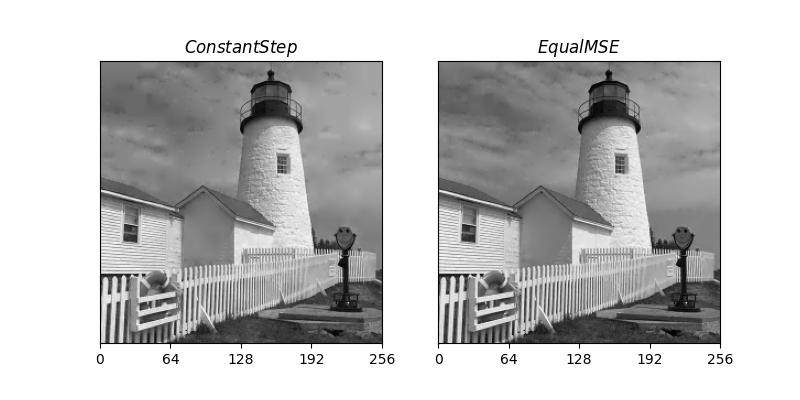

In [152]:
# Compare the images of constant optimal step size and equal MSE

constant_step = opt_step_multi_stage(X, h, 4)
Ys_q_cons = []
Ys_q_emse = []
for idx, Y_4 in enumerate(Ys_4):
    Ys_q_cons.append(quantise(Y_4,constant_step))
Z0_4 = py_dec(Ys_q_cons, quantise(X_4, constant_step), h)

for idx, Y_4 in enumerate(Ys_4):
    Ys_q_emse.append(quantise(Y_4,steps_4[idx]))
Z0_emse_4 = py_dec(Ys_q_emse,quantise(X_4,steps_4[-1]), h)

titles = ["Constant Step", "Equal MSE"]
imgs = [Z0_4, Z0_emse_4]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')


## 6.3 Changing the decimation / interpolation filter
It is also worth investigating whether a more complicated decimation / interpolation filter **h** can improve the compression. The z-transfer function of the filter used so far is

$$ h(z) = \left(\frac{1 + z^{-1}}{2}\right)^m $$

where $m = 2$. If $m$ is increased to 4(so the number of taps remains odd), the vector representation of **h** is \[1/16 4/16 6/16 4/16 1/16\]. This filter has a lower cut-off frequency than when $m=2$, so you should find that each interpolated lowpass image in the pyramid is a little more blurred, and there is a little more energy left in each highpass image.

<div class="alert alert-block alert-danger">
Optimise the step sizes for the pyramid with this new filter and determine the new compression performance and visual features.
</div>

In [153]:
# Repeat the previous experiments with a new h here
h = np.array([1, 4, 6, 4, 1]) / 16.0

In [154]:
#Repeat compression ratio for constant step sizes for multiple stage numbers

def constant_step_comp_ratio(X,Ys,X_last,step_size):
    X_q = quantise(X,17)
    Ys_q = []
    for Y in Ys:
        Ys_q.append(quantise(Y,step_size))
    X_last_q = quantise(X_last,step_size)

    bit_X = bpp(X_q) * len(X_q)**2

    comp_bit_sum = 0
    for Y in Ys_q:
        comp_bit_sum += bpp(Y) * len(Y)**2
    comp_bit_sum += bpp(X_last_q) * len(X_last_q)**2

    comp_ratio = bit_X / comp_bit_sum
    return comp_ratio

#1-stage
step_size_1 = opt_step_multi_stage(X,h,1)
print("Optimal step size for 1 stage:",step_size_1)
Ys_1, X_1 = py_enc(X,h,1)
print("1-stage comp ratio:",constant_step_comp_ratio(X,Ys_1,X_1,step_size_1))

#2-stage
step_size_2 = opt_step_multi_stage(X,h,2)
print("Optimal step size for 1 stage:",step_size_2)
Ys_2, X_2 = py_enc(X,h,2)
print("2-stage comp ratio:",constant_step_comp_ratio(X,Ys_1,X_2,step_size_2))

#3-stage
step_size_3 = opt_step_multi_stage(X,h,3)
print("Optimal step size for 3 stage:",step_size_3)
Ys_3, X_3 = py_enc(X,h,3)
print("3-stage comp ratio:",constant_step_comp_ratio(X,Ys_3,X_3,step_size_3))

#4-stage
step_size_4 = opt_step_multi_stage(X,h,4)
print("Optimal step size for 4 stage:",step_size_4)
Ys_4, X_4 = py_enc(X,h,4)
print("4-stage comp ratio:",constant_step_comp_ratio(X,Ys_4,X_4,step_size_4))

#5-stage
step_size_5 = opt_step_multi_stage(X,h,5)
print("Optimal step size for 5 stage:",step_size_5)
Ys_5, X_5 = py_enc(X,h,5)
print("5-stage comp ratio:",constant_step_comp_ratio(X,Ys_5,X_5,step_size_5))

#8-stage
step_size_8 = opt_step_multi_stage(X,h,8)
print("Optimal step size for 8 stage:",step_size_8)
Ys_8, X_8 = py_enc(X,h,8)
print("8-stage comp ratio:",constant_step_comp_ratio(X,Ys_8,X_8,step_size_8))


print("2-stage pyramid is the most efficient")

Optimal step size for 1 stage: 16.144144144144143
1-stage comp ratio: 1.2724387116375764
Optimal step size for 1 stage: 14.35035035035035
2-stage comp ratio: 1.5687435677915045
Optimal step size for 3 stage: 12.812812812812812
3-stage comp ratio: 1.2811899820996433
Optimal step size for 4 stage: 11.531531531531531
4-stage comp ratio: 1.2128531396900561
Optimal step size for 5 stage: 11.275275275275275
5-stage comp ratio: 1.1988528214914604
Optimal step size for 8 stage: 11.01901901901902
8-stage comp ratio: 1.1842004453024748
2-stage pyramid is the most efficient


In [155]:
#Repeat finding step ratios for different stages

def step_ratio(stages,h):

    #Set up test images
    X_test = np.zeros((256,256), dtype=np.float32)
    Ys, X_last = py_enc(X_test,h,stages)

    #Apply 100 amplitude impulse to each layer
    Ys_imp = []
    for Y in Ys: 
        Y_imp = Y.copy()
        Y_imp[len(Y_imp)//2,len(Y_imp)//2] = 100
        Ys_imp.append(Y_imp)
    X_last_imp = X_last.copy()
    X_last_imp[len(X_last_imp)//2,len(X_last_imp)//2] = 100

    #Find rms energy of different reconstructed image
    rmss = []
    for idx, Y_imp in enumerate(Ys_imp):
        Ys_temp = Ys.copy()
        Ys_temp[idx] = Y_imp
        rmss.append(np.sqrt(np.sum(py_dec(Ys_temp,X_last,h) ** 2)))
    rmss.append(np.sqrt(np.sum(py_dec(Ys,X_last_imp,h) ** 2)))

    #Find step ratio (assuming 0th layer is 1)
    step_ratios = [1]
    for rms in rmss[1:]:
        step_ratios.append(rmss[0]/rms)

    return step_ratios

#1-stage
step_ratio_1 = step_ratio(1,h)
print("Step ratio for 1 stage:", step_ratio_1)

#2-stage
step_ratio_2 = step_ratio(2,h)
print("Step ratio for 2 stage:", step_ratio_2)

#3-stage
step_ratio_3 = step_ratio(3,h)
print("Step ratio for 3 stage:", step_ratio_3)

#4-stage
step_ratio_4 = step_ratio(4,h)
print("Step ratio for 4 stage:", step_ratio_4)

#5-stage
step_ratio_5 = step_ratio(5,h)
print("Step ratio for 5 stage:", step_ratio_5)

#8-stage
step_ratio_8 = step_ratio(8,h)
print("Step ratio for 8 stage:", step_ratio_8)


Step ratio for 1 stage: [1, 0.9142857142857143]
Step ratio for 2 stage: [1, 0.9142857142857143, 0.5061789421651013]
Step ratio for 3 stage: [1, 0.9142857142857143, 0.5061789421651013, 0.25886572446537054]
Step ratio for 4 stage: [1, 0.9142857142857143, 0.5061789421651013, 0.25886572446537054, 0.13014447658344933]
Step ratio for 5 stage: [1, 0.9142857142857143, 0.5061789421651013, 0.25886572446537054, 0.13014447658344933, 0.06516087811520659]
Step ratio for 8 stage: [1, 0.9142857142857143, 0.5061789421651013, 0.25886572446537054, 0.13014447658344933, 0.06516087811520659, 0.032591509410513864, 0.006319683119085564, 0.00390625]


In [156]:
# Find the quantisation step size for equal mse, matching the reference RMS error
steps_1 = [ratio * step_size_1 for ratio in step_ratio_1]
steps_2 = [ratio * step_size_2 for ratio in step_ratio_2]
steps_3 = [ratio * step_size_3 for ratio in step_ratio_3]
steps_4 = [ratio * step_size_4 for ratio in step_ratio_4]
steps_5 = [ratio * step_size_5 for ratio in step_ratio_5]
steps_8 = [ratio * step_size_8 for ratio in step_ratio_8]

print("Steps for 1 stage:",steps_1)
print("Steps for 2 stage:",steps_2)
print("Steps for 3 stage:",steps_3)
print("Steps for 4 stage:",steps_4)
print("Steps for 5 stage:",steps_5)
print("Steps for 8 stage:",steps_8)

print("For pyramid beyond 5 stages, the step sizes to maintain equal MSE shrinkk below 1.")


Steps for 1 stage: [16.144144144144143, 14.760360360360359]
Steps for 2 stage: [14.35035035035035, 13.12032032032032, 7.263845160038931]
Steps for 3 stage: [12.812812812812812, 11.714571714571713, 6.485576035749045, 3.3167980712279705]
Steps for 4 stage: [11.531531531531531, 10.543114543114543, 5.8370184321741405, 2.9851182641051737, 1.5007651353767129]
Steps for 5 stage: [11.275275275275275, 10.308823108823109, 5.70730691145916, 2.9187823026806146, 1.4674147990350082, 0.7347068379276146]
Steps for 8 stage: [11.01901901901902, 10.074531674531675, 5.57759539074418, 2.852446341256055, 1.4340644626933035, 0.7180089552474416, 0.3591264620529896, 0.06963670848337726, 0.043043043043043044]
For pyramid beyond 5 stages, the step sizes to maintain equal MSE shrinkk below 1.


In [157]:
# Find the compression ratios for equal mse

def emse_comp_ratio(X,Ys,X_last,step_sizes):
    X_q = quantise(X,17)
    Ys_q = []
    for idx, Y in enumerate(Ys):
        if step_sizes[idx] >= 1:
            Ys_q.append(quantise(Y,step_sizes[idx]))
        else:
            Ys_q.append(quantise(Y,1))
    if step_sizes[-1] >= 1:
        X_last_q = quantise(X_last,step_sizes[-1])
    else:
        X_last_q = X_last

    bit_X = bpp(X_q) * len(X_q)**2

    comp_bit_sum = 0
    for Y in Ys_q:
        comp_bit_sum += bpp(Y) * len(Y)**2
    comp_bit_sum += bpp(X_last_q) * len(X_last_q)**2

    comp_ratio = bit_X / comp_bit_sum
    return comp_ratio

emse_comp_ratio_1 = emse_comp_ratio(X,Ys_1,X_1,steps_1)
print("Equal MSE compression ratio for 1 stage:", emse_comp_ratio_1)

emse_comp_ratio_2 = emse_comp_ratio(X,Ys_2,X_2,steps_2)
print("Equal MSE compression ratio for 2 stage:", emse_comp_ratio_2)

emse_comp_ratio_3 = emse_comp_ratio(X,Ys_3,X_3,steps_3)
print("Equal MSE compression ratio for 3 stage:", emse_comp_ratio_3)

emse_comp_ratio_4 = emse_comp_ratio(X,Ys_4,X_4,steps_4)
print("Equal MSE compression ratio for 4 stage:", emse_comp_ratio_4)

emse_comp_ratio_5 = emse_comp_ratio(X,Ys_5,X_5,steps_5)
print("Equal MSE compression ratio for 5 stage:", emse_comp_ratio_5)

emse_comp_ratio_8 = emse_comp_ratio(X,Ys_8,X_8,steps_8)
print("Equal MSE compression ratio for 8 stage:", emse_comp_ratio_8)


Equal MSE compression ratio for 1 stage: 1.2582886735157621
Equal MSE compression ratio for 2 stage: 1.2893732760780217
Equal MSE compression ratio for 3 stage: 1.2301313146167099
Equal MSE compression ratio for 4 stage: 1.1624786619763592
Equal MSE compression ratio for 5 stage: 1.1487634106165119
Equal MSE compression ratio for 8 stage: 1.1351399227794188


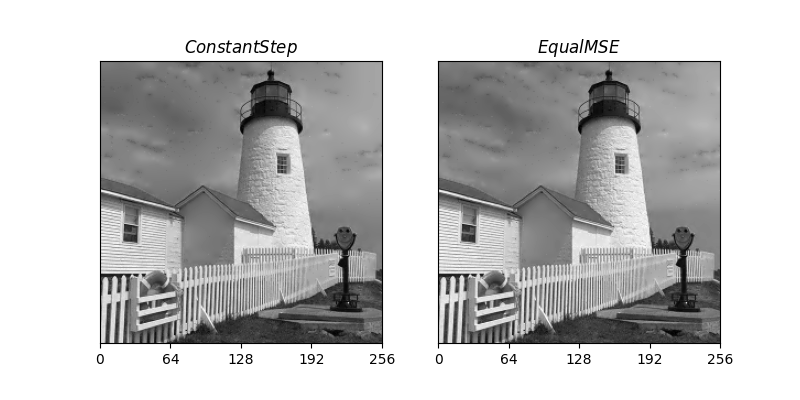

In [158]:
# Compare the images of constant optimal step size and equal MSE

constant_step = opt_step_multi_stage(X, h, 4)
Ys_q_cons = []
Ys_q_emse = []
for idx, Y_4 in enumerate(Ys_4):
    Ys_q_cons.append(quantise(Y_4,constant_step))
Z0_4 = py_dec(Ys_q_cons, quantise(X_4, constant_step), h)

for idx, Y_4 in enumerate(Ys_4):
    Ys_q_emse.append(quantise(Y_4,steps_4[idx]))
Z0_emse_4 = py_dec(Ys_q_emse,quantise(X_4,steps_4[-1]), h)

titles = ["Constant Step", "Equal MSE"]
imgs = [Z0_4, Z0_emse_4]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')


# First Interim Report
Discuss and explain your results, gathered so far, in your first interim report. Try to answer the questions posed in the above test. Be brief where things are straightforward, but pay more attention to detail in areas where you think something interesting is happening. Write this as a standalone report, not as a series of bullet points answering the questions posed.